In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/plenoi/Clinic/master/ultima_all_clean.csv')
df = df.set_index('hn')
df.head()

,age,parity,hiv,menopaus,disease,surgery,conization,OPDsize,appearance,stage,...,nodeyiel,RHlvsi,depth,size,utmet,vgmargin,vgmet,pelvicme,pmmet,adnmet
hn,,,,,,,,,,,,,,,,,,,,,
2631840,52,3,0.0,0.0,1,1,0.0,5.0,4.0,5.0,...,21.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
2633481,32,2,0.0,0.0,0,1,0.0,5.0,1.0,5.0,...,11.0,0.0,3.0,5.0,0.0,0.0,0.0,1.0,0.0,2.0
2634477,52,2,0.0,0.0,0,0,0.0,5.0,NaN,5.0,...,35.0,6.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2633633,38,2,0.0,0.0,0,0,0.0,2.0,1.0,4.0,...,20.0,16.0,3.0,3.8,0.0,0.0,0.0,0.0,0.0,2.0
2630496,55,3,0.0,1.0,0,0,1.0,0.0,5.0,4.0,...,17.0,9.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Data preprocessing

In [3]:
df.shape

(1723, 23)

In [4]:
df.isnull().sum(axis=0)

age             0
parity          0
hiv             4
menopaus        1
disease         0
surgery         0
conization      5
OPDsize        17
appearance    101
stage          24
pchemo          1
Wardsize      145
finalhisto     10
nodeyiel       12
RHlvsi        366
depth         489
size          114
utmet          98
vgmargin       96
vgmet          97
pelvicme        1
pmmet          94
adnmet          7
dtype: int64

In [5]:
df_clean_column = df.drop(['appearance','Wardsize','RHlvsi','depth','nodeyiel','vgmargin','pelvicme','adnmet'],axis = 1)
df_clean_column.isnull().sum(axis=0)

age             0
parity          0
hiv             4
menopaus        1
disease         0
surgery         0
conization      5
OPDsize        17
stage          24
pchemo          1
finalhisto     10
size          114
utmet          98
vgmet          97
pmmet          94
dtype: int64

In [6]:
df_clean = df_clean_column.dropna(axis = 0)

In [7]:
df_clean.shape

(1555, 15)

In [8]:
pel_class = np.unique(df_clean['pmmet'])
pel_class

array([0., 1.])

เช็คว่าคำตอบของข้อมูลมีอะไรบ้าง

In [9]:
pel_value = [sum(df_clean['pmmet']==pel_class[0]),
             sum(df_clean['pmmet']==pel_class[1])]
pel_value

[1278, 277]

In [10]:
y = df_clean['pmmet'].values
X = df_clean.drop(['pmmet'],axis = 1).values

Separate pelviceme dataset into data (X) and label (y)

y เป็นการเก็บคำตอบข้อมูลทั้งหมด

x เป็นคำถามทั้งหมด

In [11]:
from sklearn.model_selection import train_test_split
X, Xt, y, yt = train_test_split(X,y,test_size=0.2,random_state=0)

step ที่ 1

แบ่งข้อมูลเป็น train กับ test

sklearn เป็นคำสั่งไว้สร้าง model

test_size=0.2 เป็นคำสั่ง ระบุเปอร์เซ็นต์ ข้อนี้จะเอา train 80% และ test 20%

random_state=0 กำหนดช่วงที่จะ random ให้เป็นแบบเดียวกันหมด

***สามารถใช้คำสั่ง np + pd เพื่อใช้แบ่งได้

# Imbalance

In [12]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=1)
X, y = sm.fit_resample(X, y)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X)
X_norm = scaler.transform(X)
Xt_norm = scaler.transform(Xt)

scaler.fit(X_train) เรียนรู้ช่วงข้อมูลจาก train แล้วค่อย transform ไปเป็น trian และ test ทีหลัง โดยต้องอยู่ในช่วง 0-1

*** normalization โดยไม่ใช้ sklearn อาจจะออกสอบ

In [13]:
np.max(X_norm,0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

# Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
params = {'C': [1, 2, 6, 8, 16]}
clf = GridSearchCV(LogisticRegression(random_state=0, solver='liblinear'),params, cv=10)
clf.fit(X_norm, y)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))

Best params : {'C': 8}
10CV accuracy : 76.51960784313727


random_state ช่วยให้ผลของแต่ละคนเหมือนกัน

cv=10 การทำ training accuracy แบบ cross validation โดยที่ folds=10

หา Train Accuracy

In [17]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(Xt_norm) 
print("Test accuracy : "+str(sum(yt == y_predict)/len(yt)*100))

Test accuracy : 73.63344051446946


เป็นการ Test Accuracy 

เอา clf มา predict 

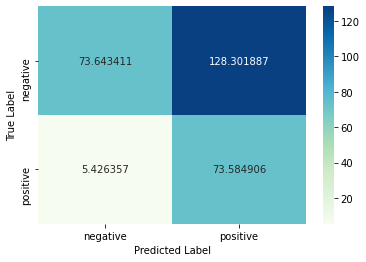

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

target_names = ['negative', 'positive']
C = confusion_matrix(yt,y_predict) #สิ่งที่เป็นจริงกับสิ่งที่ predict มันเป็นแบบไหนได้บ้าง
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt="f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

เป็นวิธีสร้าง comfution plot เพื่อดูว่าทายแม่นแค่ไหน อย่างในนี้ทายไว้ก่อนว่าไม่ติด % ที่ทายว่าไม่ติดเลยเยอะ

สามารถดูได้ว่าเวลาทายผิด มักจะทายผิดไปที่คำตอบไหนบ่อยๆ 

In [ ]:
print(classification_report(yt, y_predict, target_names=target_names))

precision ความสามารถที่จะไม่ทายว่าอยู่กลุ่มอื่น ถ้าค่าอยู่ในกลุ่มอื่นค่าจะตกลง เช่น ทำนายว่า ไม่เป็นโรค(negetive) แล้วผู้ป่วยเป็นโรค(positive)

recall ความสามารถที่จะทายค่าถูก ยิ่งทายถูก % จะยิ่งสูง เช่น ทำนายว่า ไม่เป็นโรค(negetive) แล้วผู้ป่วยไม่เป็นโรคจริงๆ

f1-score ศักยภาพโดยรวมเป็นเท่าไหร่

support จำนวนข้อมูลใน class นั้นๆมีกี่ตัว

# Support Vector machine

In [25]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
params = {
    'C' : [1,2,4,8,16], 
    'gamma' : [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32] # High gamma = Overfitting
}
clf = GridSearchCV(SVC(),params, cv=10)
clf.fit(X_norm, y)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))

Best params : {'C': 4, 'gamma': 16}
10CV accuracy : 91.12745098039214


In [27]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(Xt_norm) 
print("Test accuracy : "+str(sum(yt == y_predict)/len(yt)*100))

Test accuracy : 77.17041800643086


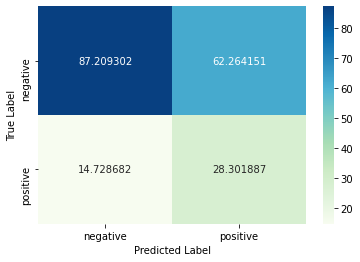

In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

target_names = ['negative', 'positive']
C = confusion_matrix(yt,y_predict) #สิ่งที่เป็นจริงกับสิ่งที่ predict มันเป็นแบบไหนได้บ้าง
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt="f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [29]:
print(classification_report(yt, y_predict, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.86      0.87      0.86       258
    positive       0.31      0.28      0.30        53

    accuracy                           0.77       311
   macro avg       0.58      0.58      0.58       311
weighted avg       0.76      0.77      0.77       311

